In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pandas as pd
from PIL import Image
import natsort
import cv2
from loguru import logger
from sklearn.model_selection import train_test_split

In [2]:
DATASET_VERSION = "V2"
BASE_DIR = f"/mnt/disk/dataset/sentinel-ai-processor/{DATASET_VERSION}"
INPUT_DIR = os.path.join(BASE_DIR, "input")
TARGET_DIR = os.path.join(BASE_DIR, "output")
df_input = pd.read_csv(f"{BASE_DIR}/input_l1c.csv", index_col=0)
df_target = pd.read_csv(f"{BASE_DIR}/output_l2a.csv", index_col=0)

In [3]:
logger.info(f"L1C product:  {len(df_input)}")
logger.info(f"L2A product {len(df_target)}")

2025-04-24 12:15:25.711 | INFO     | __main__:<module>:1 - L1C product:  58045
2025-04-24 12:15:25.716 | INFO     | __main__:<module>:2 - L2A product 58045


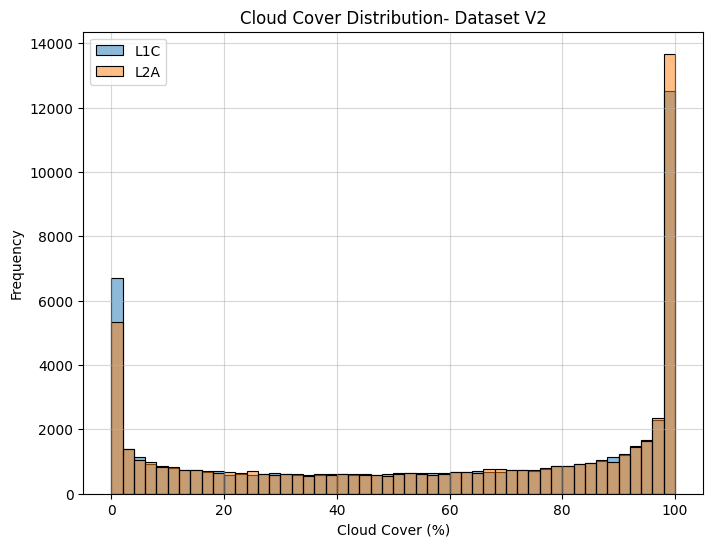

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot histograms of cloud_cover
plt.figure(figsize=(8, 6))
sns.histplot(df_input['cloud_cover'], bins=50, label='L1C', alpha=0.5)
sns.histplot(df_target['cloud_cover'], bins=50,label='L2A', alpha=0.5)
plt.xlabel('Cloud Cover (%)')
plt.ylabel('Frequency')
plt.title(f'Cloud Cover Distribution- Dataset {DATASET_VERSION}')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime

def extract_date_info(df, id_column='id_key'):
    """
    Extract date information from the given dataframe.

    Args:
        df (pd.DataFrame): Input dataframe.
        id_column (str): Column name containing the ID string.

    Returns:
        pd.DataFrame: Dataframe with additional date columns.
    """
    # Extract date from id_key
    def extract_date_from_id(id_key):
        """Extract the date part (YYYYMMDD) from Sentinel-2 ID string"""
        match = re.search(r'_(\d{8})T', id_key)
        if match:
            return match.group(1)
        return None

    # Apply the extraction to the dataframe
    df['date_str'] = df[id_column].apply(extract_date_from_id)

    # Convert to datetime and extract month information
    df['date'] = pd.to_datetime(df['date_str'], format='%Y%m%d')
    df['month'] = df['date'].dt.month
    df['month_name'] = df['date'].dt.strftime('%b')
    df['year_month'] = df['date'].dt.strftime('%Y-%m')

    return df


def plot_monthly_distribution(df):
    """
    Create bar plots for data counts per month and year-month.

    Args:
        df (pd.DataFrame): Input dataframe with date information.

    Returns:
        None
    """
    # Create a count of data points by month
    monthly_counts = df['month_name'].value_counts().sort_index()

    # Sort the months in chronological order
    month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    monthly_counts = monthly_counts.reindex(month_order)

    # Create a bar plot for data counts per month
    plt.figure(figsize=(18, 6))
    monthly_counts.plot(kind='bar', color=sns.color_palette("viridis", len(monthly_counts)))
    plt.xlabel('Month')
    plt.ylabel('Number of Data Points')
    plt.title('Distribution of Data by Month')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)

    # Add count labels on top of bars
    for i, count in enumerate(monthly_counts):
        plt.text(i, count + (max(monthly_counts) * 0.02), str(count), ha='center')

    plt.tight_layout()
    plt.show()

    # For a more detailed view, you could also plot by year-month
    # (if your data spans multiple years)
    yearly_monthly_counts = df['year_month'].value_counts().sort_index()

    plt.figure(figsize=(18, 6))
    yearly_monthly_counts.plot(kind='bar', color=sns.color_palette("mako", len(yearly_monthly_counts)))
    plt.xlabel('Year-Month')
    plt.ylabel('Number of Data Points')
    plt.title('Distribution of Data by Year and Month')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)

    # Add count labels on top of bars
    for i, count in enumerate(yearly_monthly_counts):
        plt.text(i, count + (max(yearly_monthly_counts) * 0.01), str(count), ha='center')

    plt.tight_layout()
    plt.show()

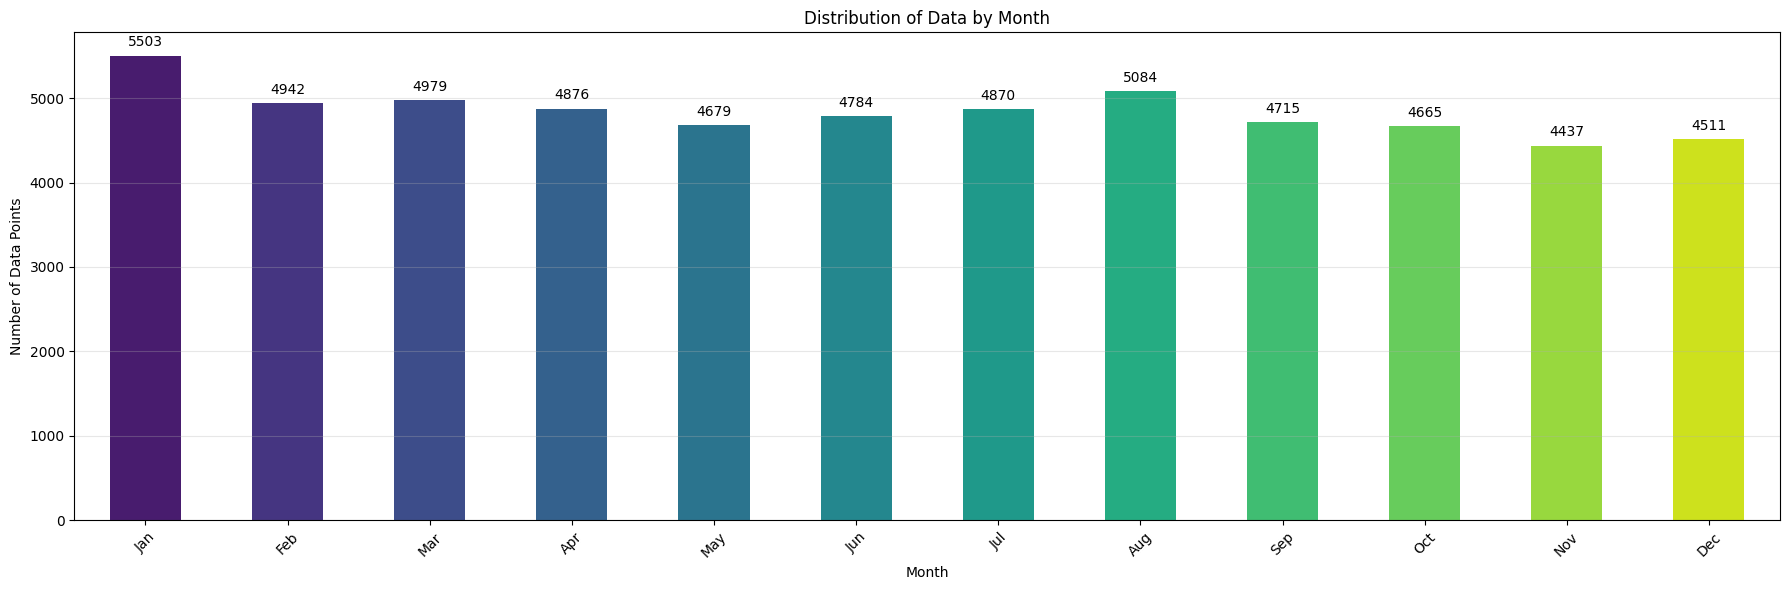

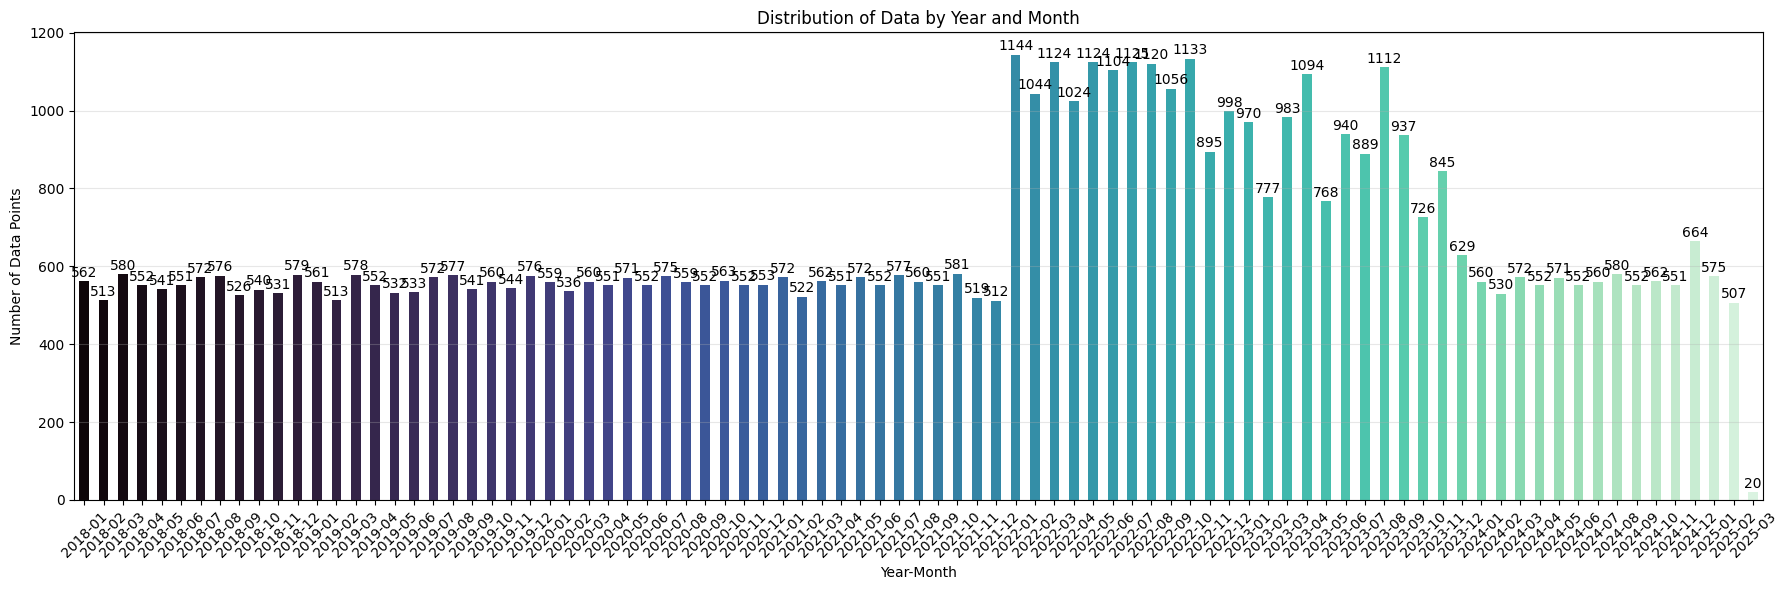

In [6]:
df_target = extract_date_info(df_target)
plot_monthly_distribution(df_target)


Using 1455 samples per bin based on minimum available


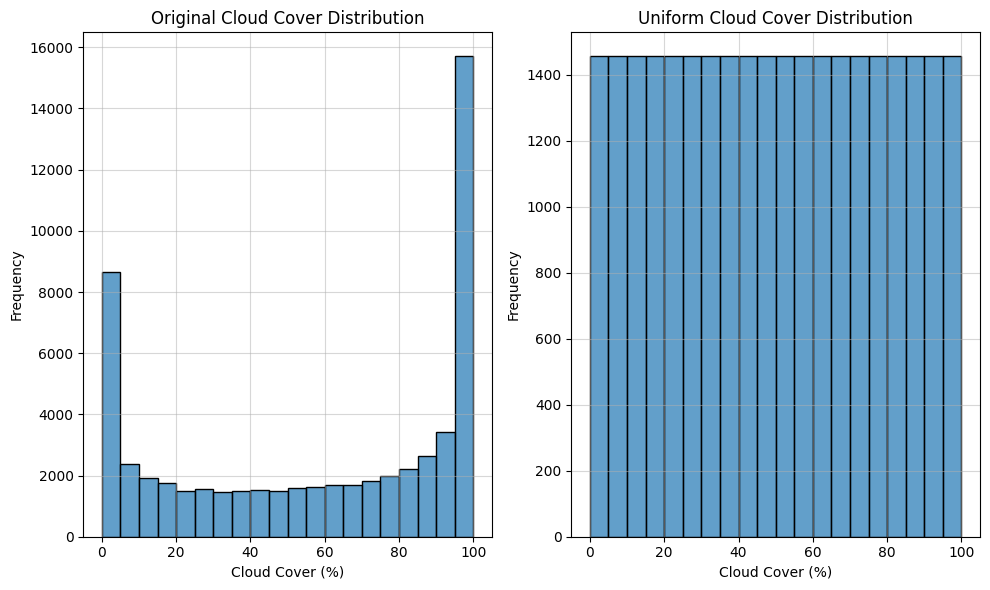

Original dataset size: 58045
Uniform dataset size: 29100


In [7]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample

def create_uniform_cloud_cover_distribution(df_input, df_target, num_bins=10, samples_per_bin=None):
    """
    Create datasets with uniform cloud cover distribution

    Args:
        df_input: Input dataframe
        df_target: Target dataframe
        num_bins: Number of bins to divide the cloud cover range (0-100%)
        samples_per_bin: Number of samples to select per bin (if None, uses minimum available)

    Returns:
        Filtered input and target dataframes with uniform cloud cover distribution
    """
    # Create bins for cloud cover
    bin_edges = np.linspace(0, 100, num_bins+1)

    # Initialize empty dataframes for uniform distribution datasets
    uniform_input = pd.DataFrame()
    uniform_target = pd.DataFrame()

    # Track samples per bin
    bin_counts = []

    # First pass to determine minimum samples across bins if samples_per_bin isn't specified
    if samples_per_bin is None:
        for i in range(len(bin_edges)-1):
            bin_start = bin_edges[i]
            bin_end = bin_edges[i+1]

            # Count samples in this bin
            bin_samples = len(df_input[(df_input['cloud_cover'] >= bin_start) &
                                       (df_input['cloud_cover'] < bin_end)])
            bin_counts.append(bin_samples)

        samples_per_bin = min(bin_counts)
        print(f"Using {samples_per_bin} samples per bin based on minimum available")

    # Process each bin
    for i in range(len(bin_edges)-1):
        bin_start = bin_edges[i]
        bin_end = bin_edges[i+1]

        # Filter indices for samples in current bin
        bin_indices = df_input[(df_input['cloud_cover'] >= bin_start) &
                               (df_input['cloud_cover'] < bin_end)].index.tolist()

        # Skip if no samples in this bin
        if not bin_indices:
            print(f"Warning: No samples in bin {bin_start}-{bin_end}")
            continue

        # If we have fewer samples than needed, use all with replacement
        if len(bin_indices) < samples_per_bin:
            # Resample with replacement
            selected_indices = random.choices(bin_indices, k=samples_per_bin)
        else:
            # Randomly select indices without replacement
            selected_indices = random.sample(bin_indices, samples_per_bin)

        # Add selected samples to the uniform datasets
        uniform_input = pd.concat([uniform_input, df_input.loc[selected_indices]])
        uniform_target = pd.concat([uniform_target, df_target.loc[selected_indices]])

    return uniform_input, uniform_target

# Apply the function to create uniformly distributed datasets
# You can adjust num_bins for finer granularity and samples_per_bin for dataset size
num_bins = 20  # 5% cloud cover range per bin
uniform_df_input, uniform_df_target = create_uniform_cloud_cover_distribution(
    df_input, df_target, num_bins=num_bins)

# Plot to verify uniform distribution
plt.figure(figsize=(10, 6))

# Original distribution
plt.subplot(1, 2, 1)
sns.histplot(df_input['cloud_cover'], bins=num_bins, label='Original', alpha=0.7)
plt.xlabel('Cloud Cover (%)')
plt.ylabel('Frequency')
plt.title('Original Cloud Cover Distribution')
plt.grid(True, alpha=0.5)

# Uniform distribution
plt.subplot(1, 2, 2)
sns.histplot(uniform_df_input['cloud_cover'], bins=num_bins, label='Uniform', alpha=0.7)
plt.xlabel('Cloud Cover (%)')
plt.ylabel('Frequency')
plt.title('Uniform Cloud Cover Distribution')
plt.grid(True, alpha=0.5)

plt.tight_layout()
plt.show()

# Print statistics
print(f"Original dataset size: {len(df_input)}")
print(f"Uniform dataset size: {len(uniform_df_input)}")

In [8]:
uniform_df_input = uniform_df_input.reset_index(drop=True)
uniform_df_target = uniform_df_target.reset_index(drop=True)

In [9]:
# for i in range(min(len(uniform_df_input), len(uniform_df_target))):
#     if uniform_df_input['id_key'][i] == uniform_df_target['id_key'][i]:
#         print(f"Match: {uniform_df_input['id_key'][i]} == {uniform_df_target['id_key'][i]}")
#     else:
#         print(f"Mismatch: {uniform_df_input['id_key'][i]} != {uniform_df_target['id_key'][i]}")

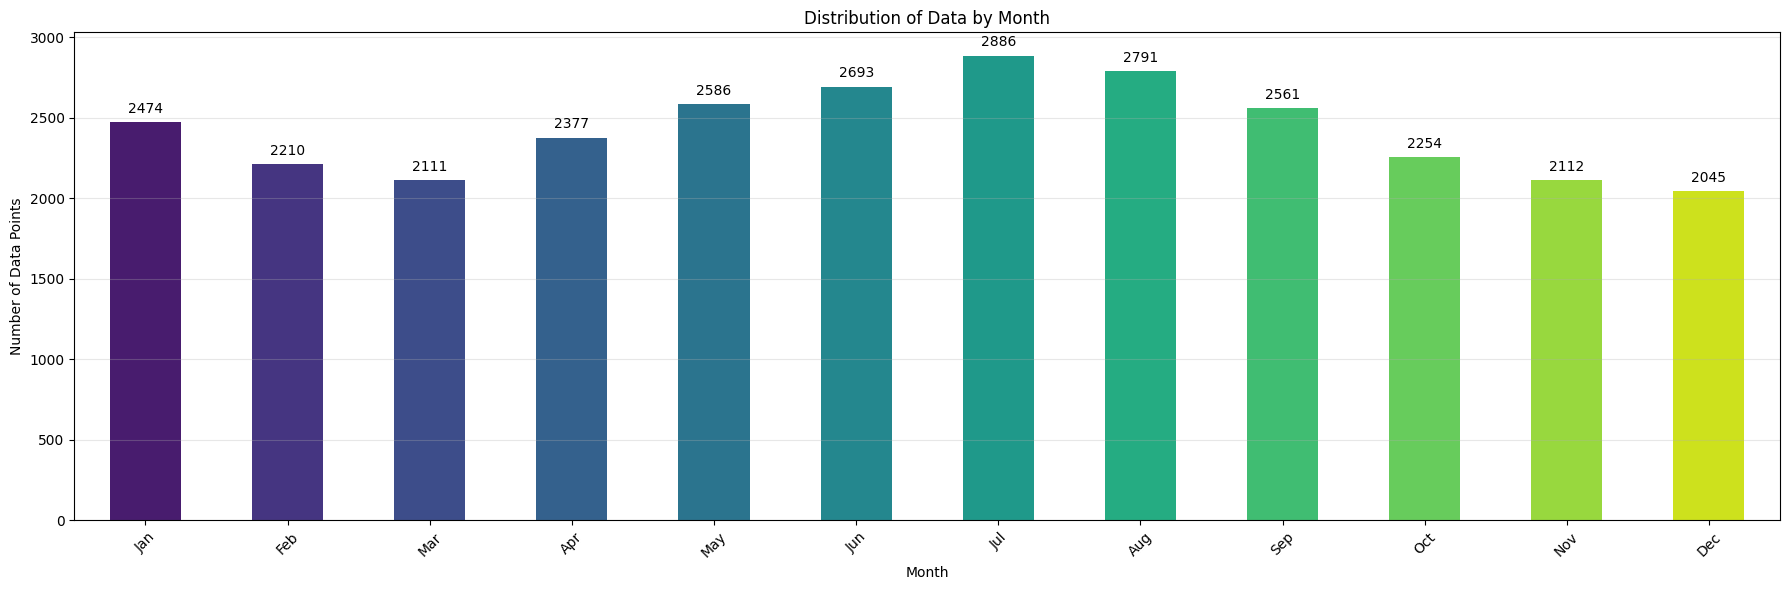

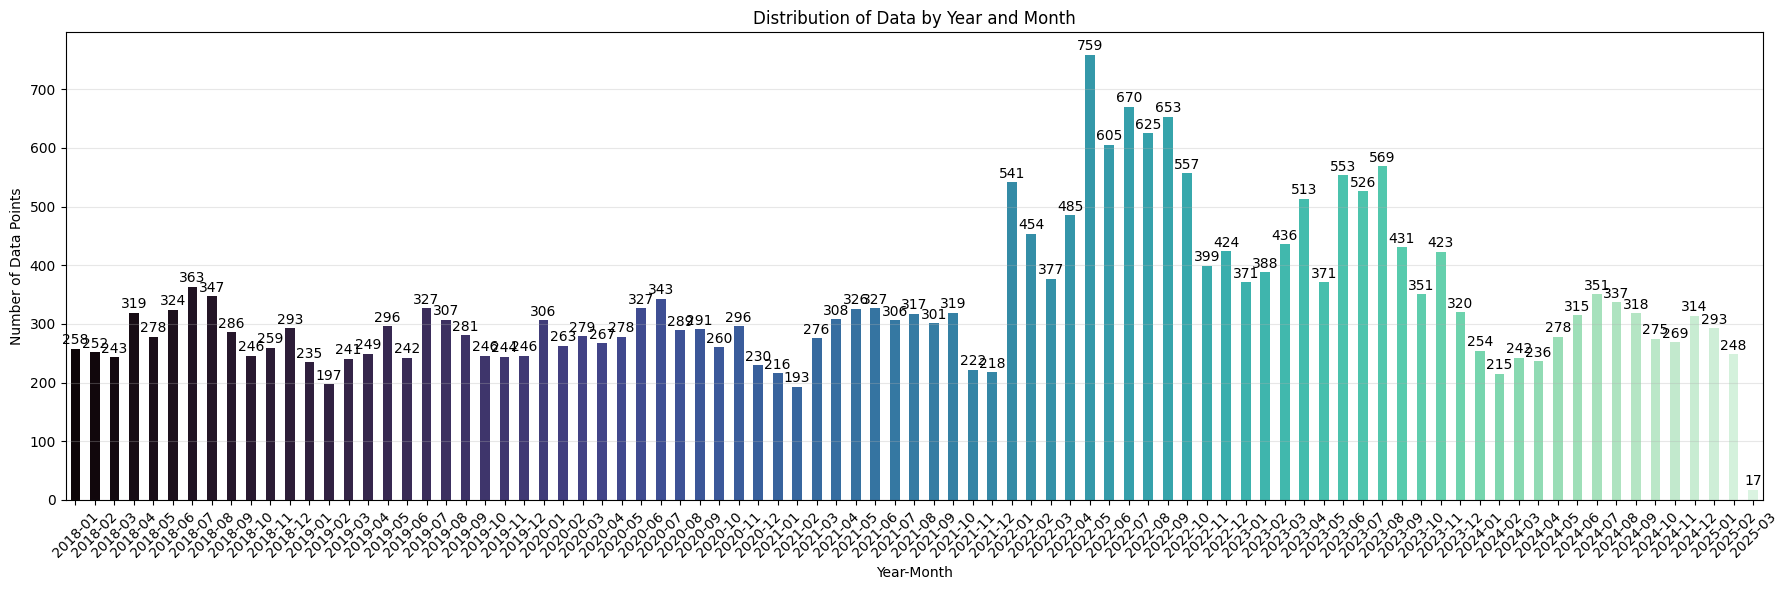

In [10]:


uniform_df_input = extract_date_info(uniform_df_input)
plot_monthly_distribution(uniform_df_input)


In [11]:
# sample Data

uniform_df_input = uniform_df_input.sample(n=6000, random_state=42, replace=False)
uniform_df_target = uniform_df_target.loc[uniform_df_input.index]

Split data into:
  Training:   4800 samples (80.0%)
  Validation: 600 samples (10.0%)
  Test:       600 samples (10.0%)


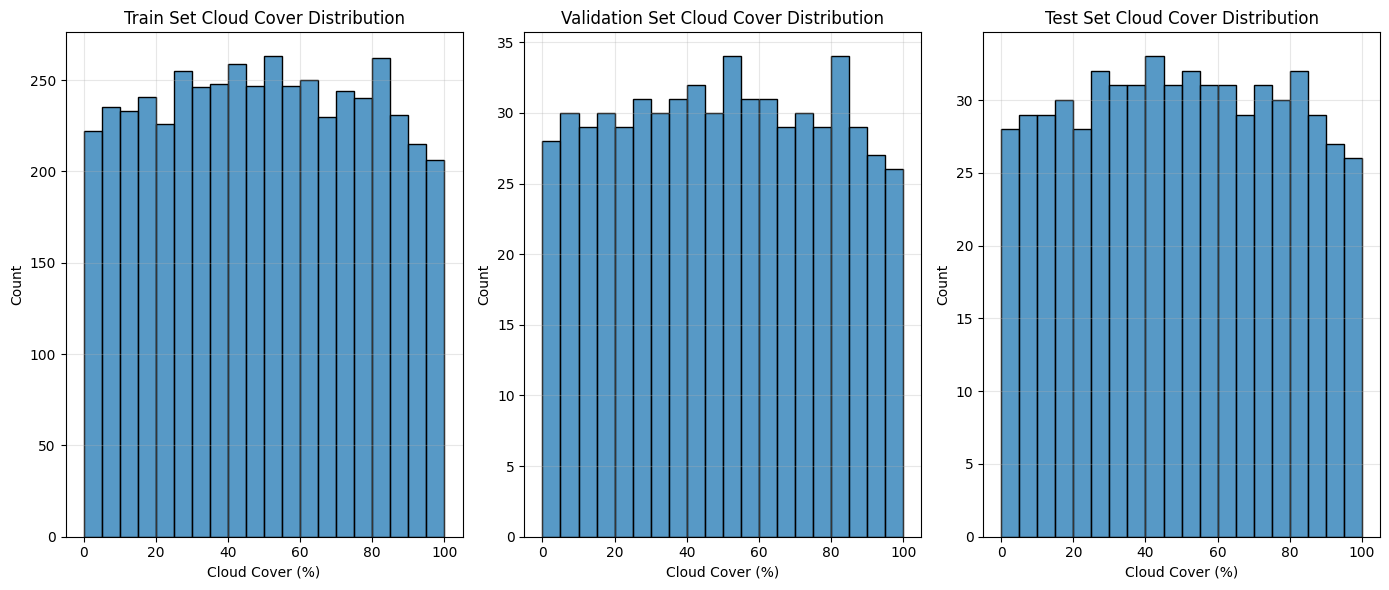

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

def split_dataset_stratified_by_cloud_cover(df_input, df_target, train_size=0.7, val_size=0.15, test_size=0.15, num_bins=10, random_state=42):
    """
    Split dataset into train/val/test while preserving cloud cover distribution

    Args:
        df_input: Input dataframe
        df_target: Target dataframe
        train_size: Proportion for training set (default 0.7)
        val_size: Proportion for validation set (default 0.15)
        test_size: Proportion for test set (default 0.15)
        num_bins: Number of bins to divide cloud cover for stratification
        random_state: Random seed for reproducibility

    Returns:
        Six dataframes: input_train, input_val, input_test, target_train, target_val, target_test
    """
    assert np.isclose(train_size + val_size + test_size, 1.0), "Split proportions must sum to 1.0"

    # Create cloud cover bins for stratification
    df_input['cloud_cover_bin'] = pd.cut(df_input['cloud_cover'], bins=num_bins, labels=False)

    # First split: train and temp (val+test combined)
    temp_size = val_size + test_size
    relative_val_size = val_size / temp_size  # For the second split

    input_train, input_temp, target_train, target_temp = train_test_split(
        df_input, df_target,
        train_size=train_size,
        stratify=df_input['cloud_cover_bin'],
        random_state=random_state
    )

    # Second split: divide temp into val and test
    input_val, input_test, target_val, target_test = train_test_split(
        input_temp, target_temp,
        train_size=relative_val_size,
        stratify=input_temp['cloud_cover_bin'],
        random_state=random_state
    )

    # Drop the stratification column
    input_train = input_train.drop('cloud_cover_bin', axis=1)
    input_val = input_val.drop('cloud_cover_bin', axis=1)
    input_test = input_test.drop('cloud_cover_bin', axis=1)

    input_train = input_train.reset_index(drop=True)
    input_val = input_val.reset_index(drop=True)
    input_test = input_test.reset_index(drop=True)
    target_train = target_train.reset_index(drop=True)
    target_val = target_val.reset_index(drop=True)
    target_test = target_test.reset_index(drop=True)





    # Report split sizes
    print(f"Split data into:")
    print(f"  Training:   {len(input_train)} samples ({len(input_train)/len(df_input):.1%})")
    print(f"  Validation: {len(input_val)} samples ({len(input_val)/len(df_input):.1%})")
    print(f"  Test:       {len(input_test)} samples ({len(input_test)/len(df_input):.1%})")

    return input_train, input_val, input_test, target_train, target_val, target_test



# Perform the split
input_train, input_val, input_test, target_train, target_val, target_test = split_dataset_stratified_by_cloud_cover(
    uniform_df_input, uniform_df_target,
    train_size=0.8, val_size=0.10, test_size=0.10,
    num_bins=20, random_state=42
)

# Visualize cloud cover distribution across splits
plt.figure(figsize=(14, 6))

# Plot histograms for each split
plt.subplot(1, 3, 1)
sns.histplot(input_train['cloud_cover'], bins=20)
plt.title('Train Set Cloud Cover Distribution')
plt.xlabel('Cloud Cover (%)')
plt.ylabel('Count')
plt.grid(alpha=0.3)

plt.subplot(1, 3, 2)
sns.histplot(input_val['cloud_cover'], bins=20)
plt.title('Validation Set Cloud Cover Distribution')
plt.xlabel('Cloud Cover (%)')
plt.ylabel('Count')
plt.grid(alpha=0.3)

plt.subplot(1, 3, 3)
sns.histplot(input_test['cloud_cover'], bins=20)
plt.title('Test Set Cloud Cover Distribution')
plt.xlabel('Cloud Cover (%)')
plt.ylabel('Count')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

<Figure size 1800x600 with 0 Axes>

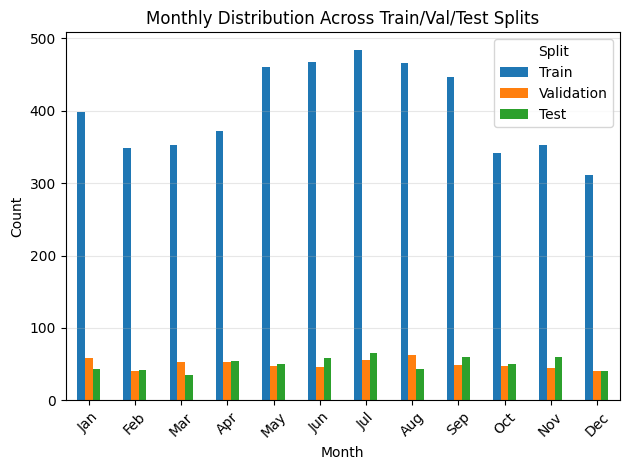

In [13]:
# Compare month distribution across splits
def plot_monthly_distribution_by_split(train_df, val_df, test_df, title='Monthly Distribution by Split'):
    """Plot monthly distribution across train/val/test splits"""
    month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    train_months = train_df['month_name'].value_counts().reindex(month_order).fillna(0)
    val_months = val_df['month_name'].value_counts().reindex(month_order).fillna(0)
    test_months = test_df['month_name'].value_counts().reindex(month_order).fillna(0)

    # Combine into a DataFrame for plotting
    monthly_dist = pd.DataFrame({
        'Train': train_months,
        'Validation': val_months,
        'Test': test_months
    })

    # Plot
    plt.figure(figsize=(18, 6))
    monthly_dist.plot(kind='bar')
    plt.title(title)
    plt.xlabel('Month')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.legend(title='Split')
    plt.tight_layout()
    plt.show()

    return monthly_dist

# Plot monthly distribution
monthly_dist = plot_monthly_distribution_by_split(input_train, input_val, input_test, title='Monthly Distribution Across Train/Val/Test Splits')

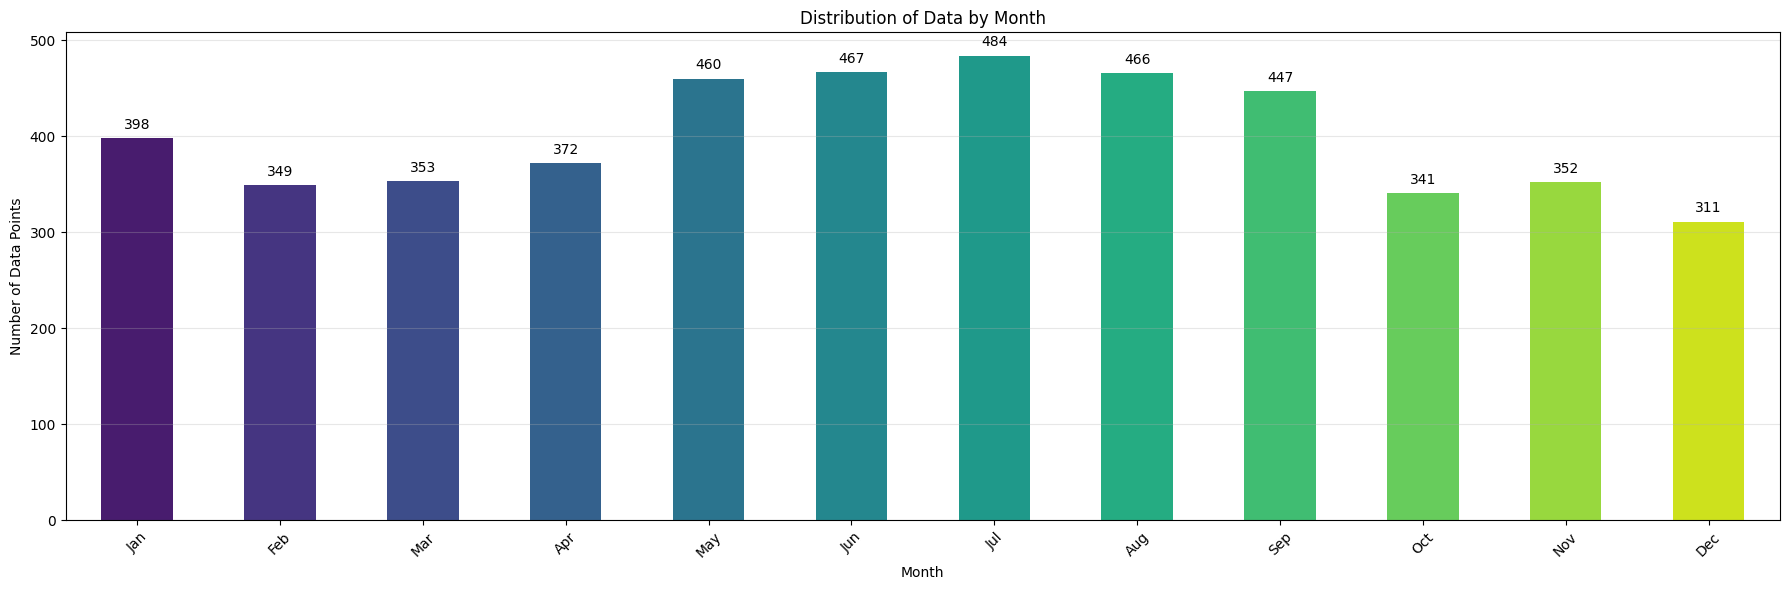

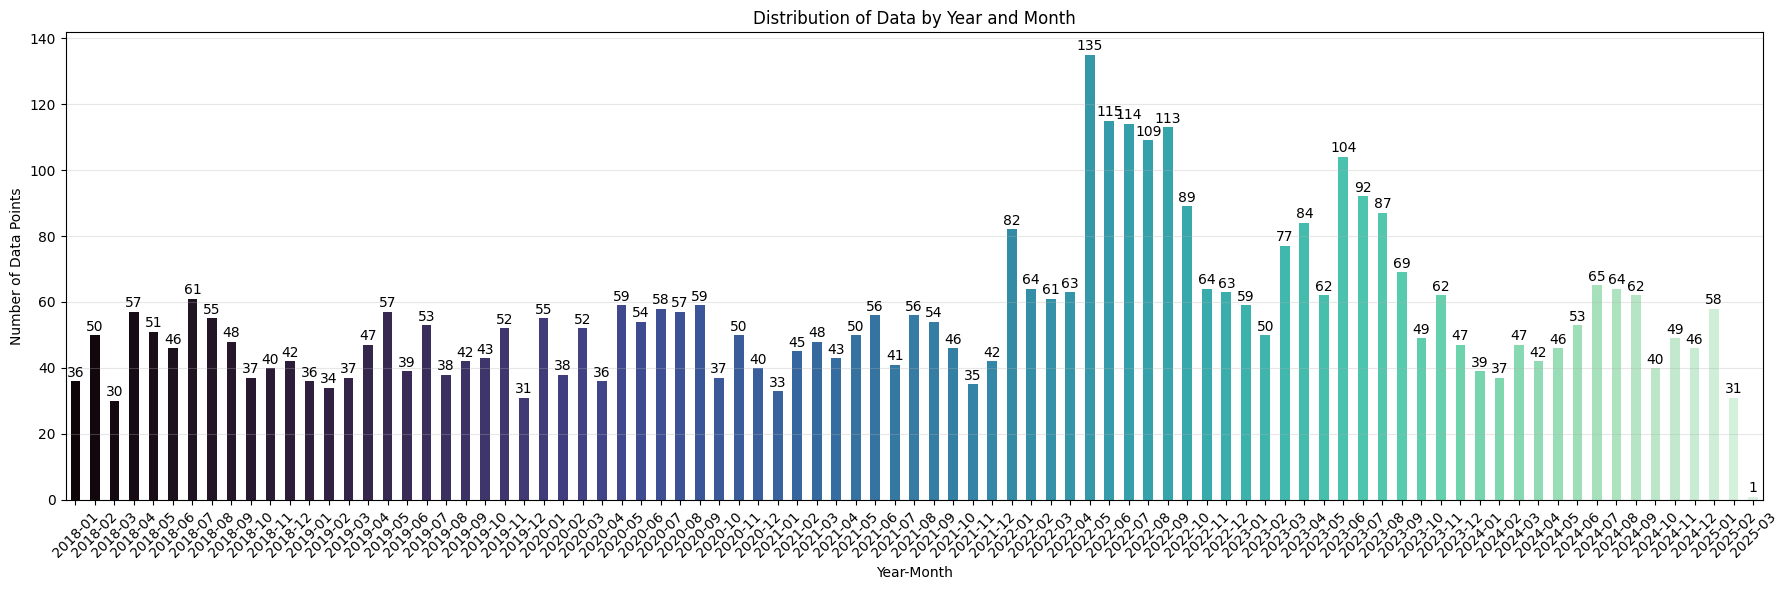

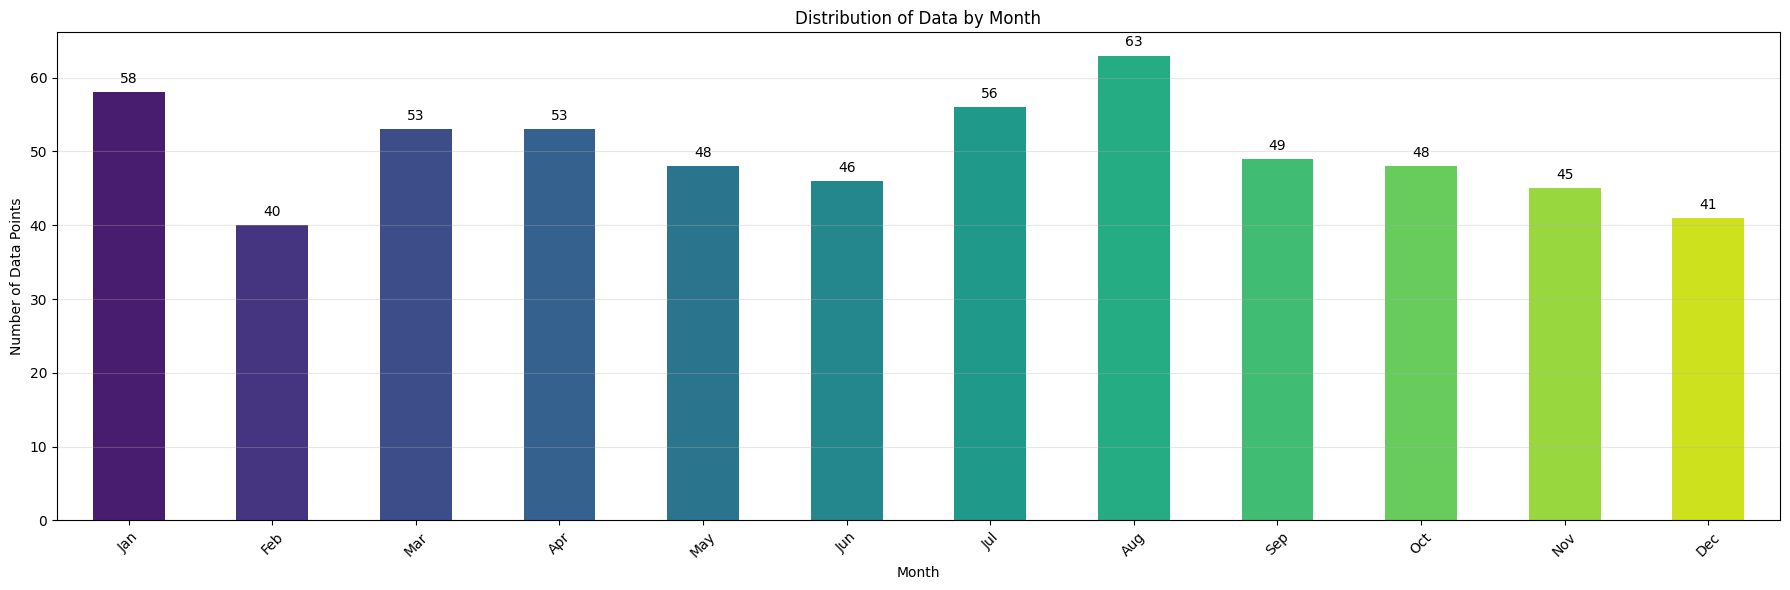

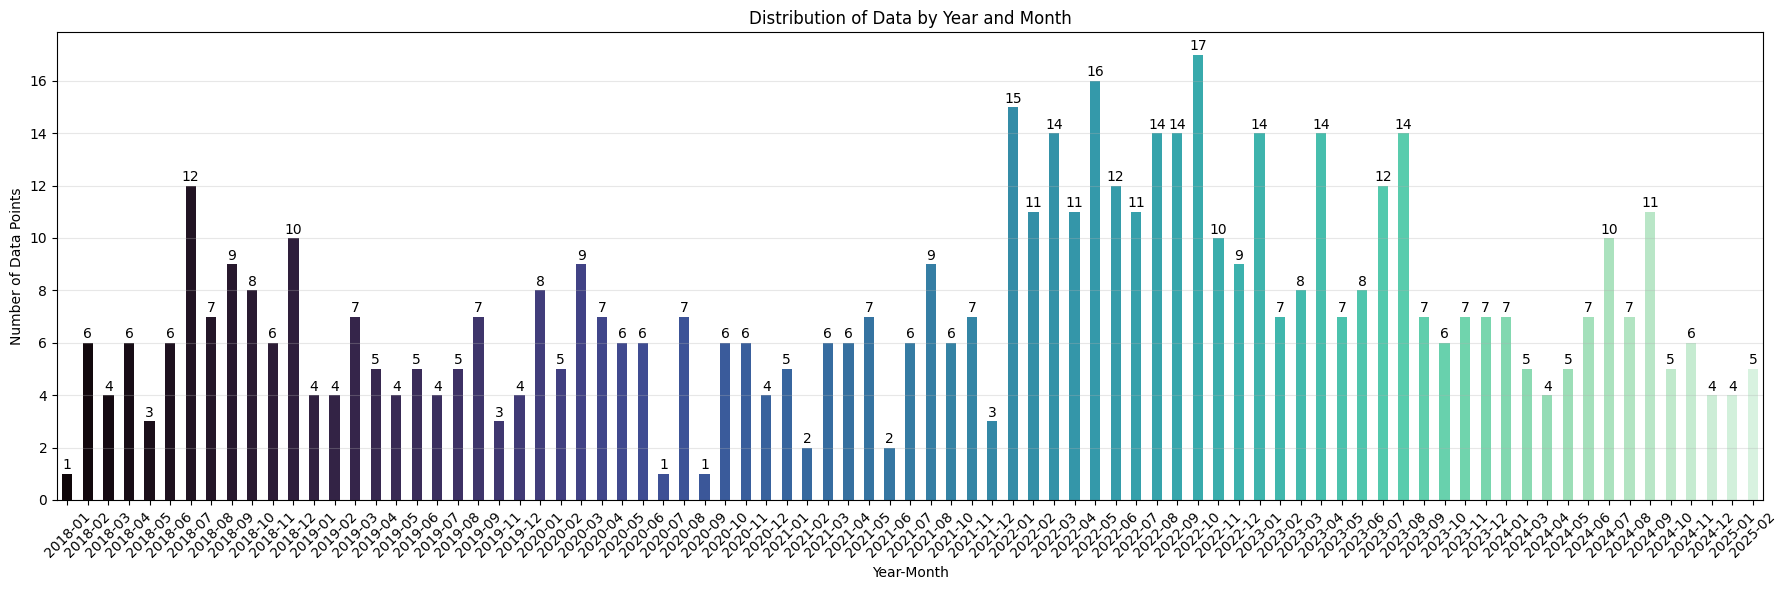

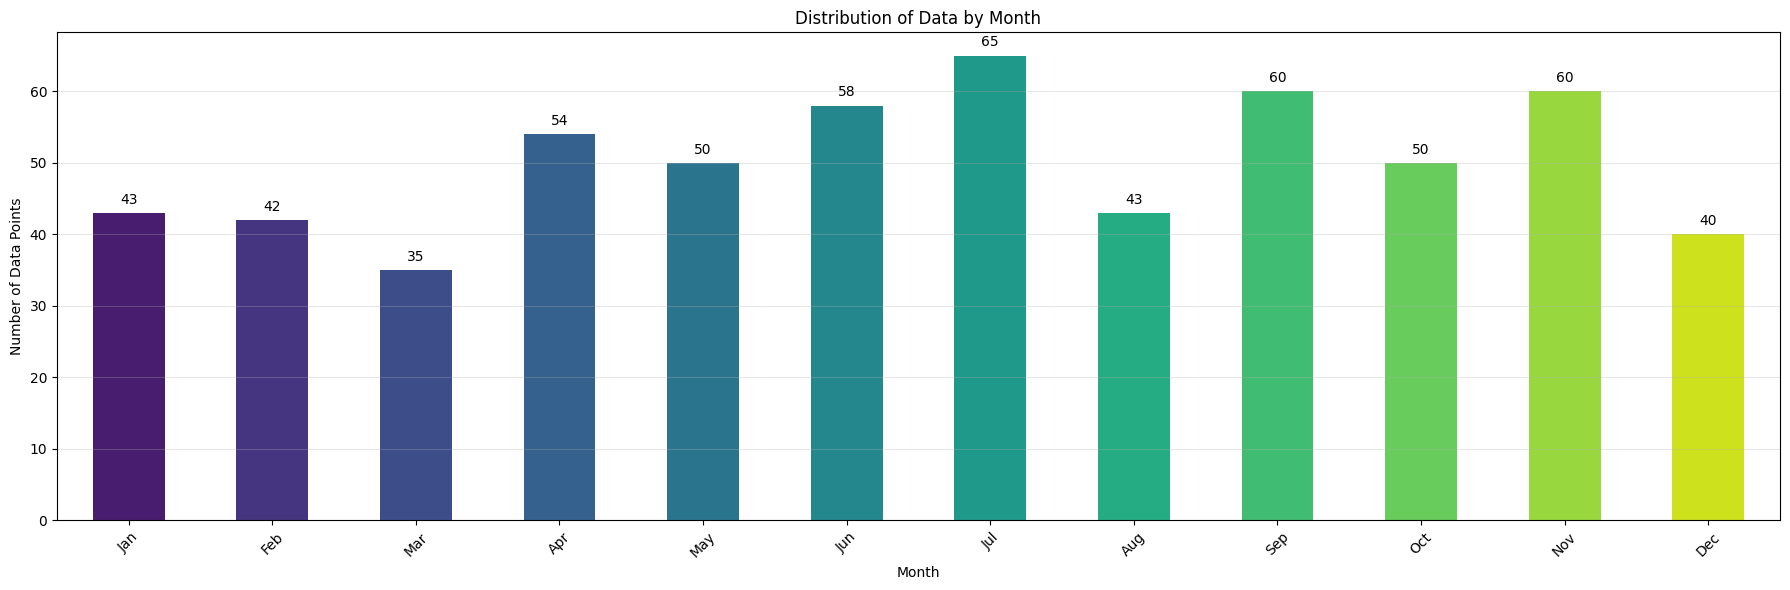

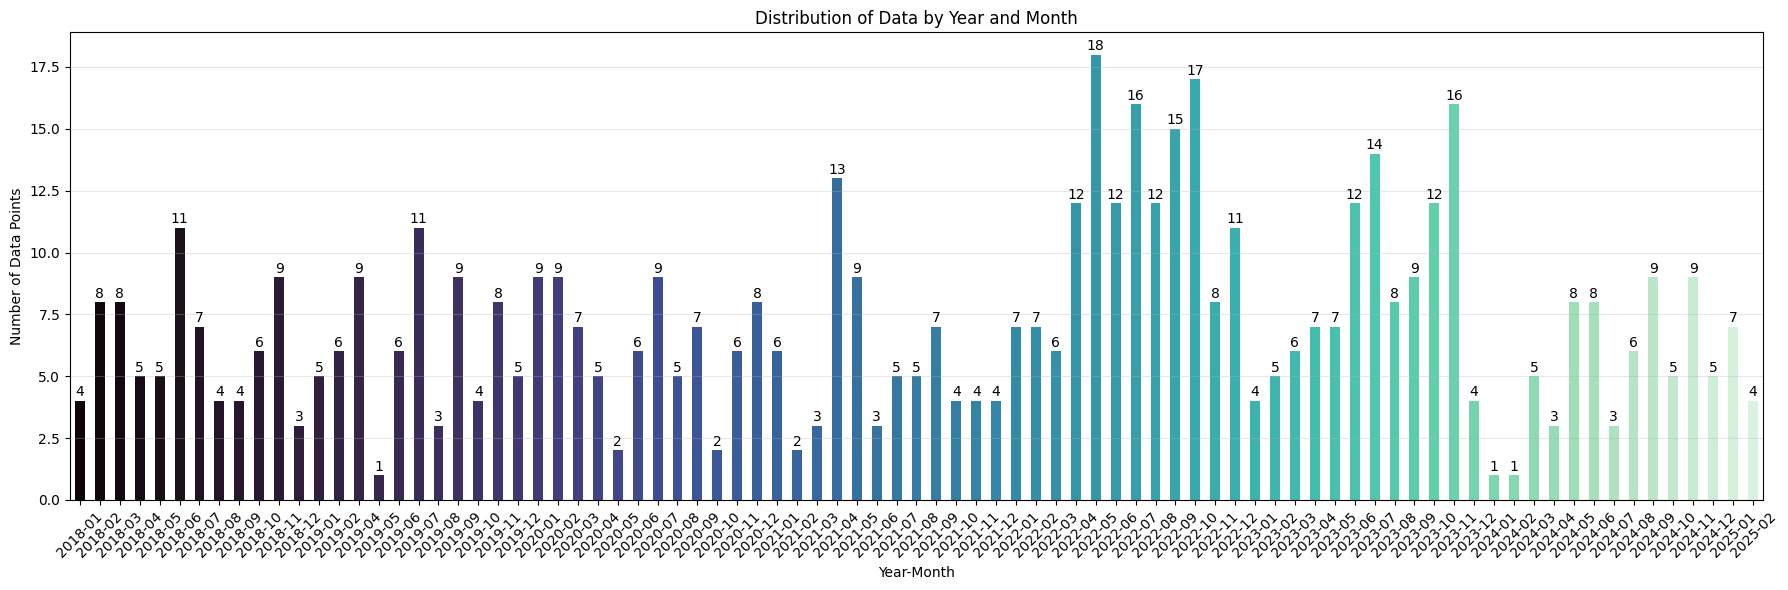

In [14]:
plot_monthly_distribution(input_train)
plot_monthly_distribution(input_val)
plot_monthly_distribution(input_test)

In [15]:
import os

# Define the base directory
base_dir = BASE_DIR

# Create the directory structure
for split in ['train', 'val', 'test']:
    split_dir = os.path.join(base_dir, split)
    os.makedirs(split_dir, exist_ok=True)
    os.makedirs(os.path.join(split_dir, 'input'), exist_ok=True)
    os.makedirs(os.path.join(split_dir, 'target'), exist_ok=True)

In [16]:
logger.info(f" TRAIN  L1C product:  {len(input_train)}")
logger.info(f"TRAIN L2A product {len(target_train)}")

logger.info(f"VAL L1C product:  {len(input_val)}")
logger.info(f"VAL L2A product {len(target_val)}")

logger.info(f"TEST L1C product:  {len(input_test)}")
logger.info(f"TEST L2A product {len(target_test)}")

2025-04-24 12:15:29.984 | INFO     | __main__:<module>:1 -  TRAIN  L1C product:  4800
2025-04-24 12:15:29.984 | INFO     | __main__:<module>:2 - TRAIN L2A product 4800
2025-04-24 12:15:29.985 | INFO     | __main__:<module>:4 - VAL L1C product:  600
2025-04-24 12:15:29.985 | INFO     | __main__:<module>:5 - VAL L2A product 600
2025-04-24 12:15:29.986 | INFO     | __main__:<module>:7 - TEST L1C product:  600
2025-04-24 12:15:29.986 | INFO     | __main__:<module>:8 - TEST L2A product 600


In [17]:
# Save the sampled data to the corresponding directories
# input_train.to_csv(os.path.join(base_dir, 'train/input.csv'), index=False)
# target_train.to_csv(os.path.join(base_dir, 'train/target.csv'), index=False)

# input_val.to_csv(os.path.join(base_dir, 'val/input.csv'), index=False)
# target_val.to_csv(os.path.join(base_dir, 'val/target.csv'), index=False)

# input_test.to_csv(os.path.join(base_dir, 'test/input.csv'), index=False)
# target_test.to_csv(os.path.join(base_dir, 'test/target.csv'), index=False)

## Missing values analysis

In [18]:
import cv2
import numpy as np
import pandas as pd
import os
import glob
from tqdm import tqdm

# Define dataset version and paths
DATASET_VERSION = "V2"
TRAIN_DIR = f"/mnt/disk/dataset/sentinel-ai-processor/{DATASET_VERSION}/train/"
VAL_DIR = f"/mnt/disk/dataset/sentinel-ai-processor/{DATASET_VERSION}/val/"
TEST_DIR = f"/mnt/disk/dataset/sentinel-ai-processor/{DATASET_VERSION}/test/"

# Function to prepare dataframe with valid paths
def prepare_dataset_df(base_dir):
    df = pd.read_csv(f"{base_dir}/input.csv", index_col=0)
    df["l1c_path"] = df["Name"].apply(lambda x: os.path.join(base_dir, 'input', os.path.basename(x).replace(".SAFE","")))
    df["l1c_path"] = df["l1c_path"].apply(lambda x: glob.glob(os.path.join(x, "*.png")))
    df["l1c_path"] = df["l1c_path"].apply(lambda file_list: file_list[0] if len(file_list) > 0 else None)
    valid_indices = df[df["l1c_path"].notna()].index
    return df.loc[valid_indices]

# Prepare dataframes
df_train = prepare_dataset_df(TRAIN_DIR)
df_val = prepare_dataset_df(VAL_DIR)
df_test = prepare_dataset_df(TEST_DIR)

In [19]:
# Function to compute missing value percentage
def compute_missing_value(path):
    try:
        x_data = cv2.imread(path)
        total_pixels = x_data.shape[0] * x_data.shape[1]
        num_zero_pixels = np.sum(np.all(x_data != 0, axis=-1))
        percentage_zero_pixels = (num_zero_pixels / total_pixels) * 100
        return percentage_zero_pixels
    except Exception as e:
        print(f"Error processing {path}: {str(e)}")
        return np.nan

# Compute missing values for each dataset
missing_values_train = []
for i in tqdm(range(len(df_train)), desc="Computing missing values - Train"):
    missing_values_train.append(compute_missing_value(df_train['l1c_path'].iloc[i]))
df_train['missing_value_percentage'] = missing_values_train

missing_values_val = []
for i in tqdm(range(len(df_val)), desc="Computing missing values - Val"):
    missing_values_val.append(compute_missing_value(df_val['l1c_path'].iloc[i]))
df_val['missing_value_percentage'] = missing_values_val

missing_values_test = []
for i in tqdm(range(len(df_test)), desc="Computing missing values - Test"):
    missing_values_test.append(compute_missing_value(df_test['l1c_path'].iloc[i]))
df_test['missing_value_percentage'] = missing_values_test

Computing missing values - Test: 100%|██████████| 600/600 [01:08<00:00,  8.70it/s]


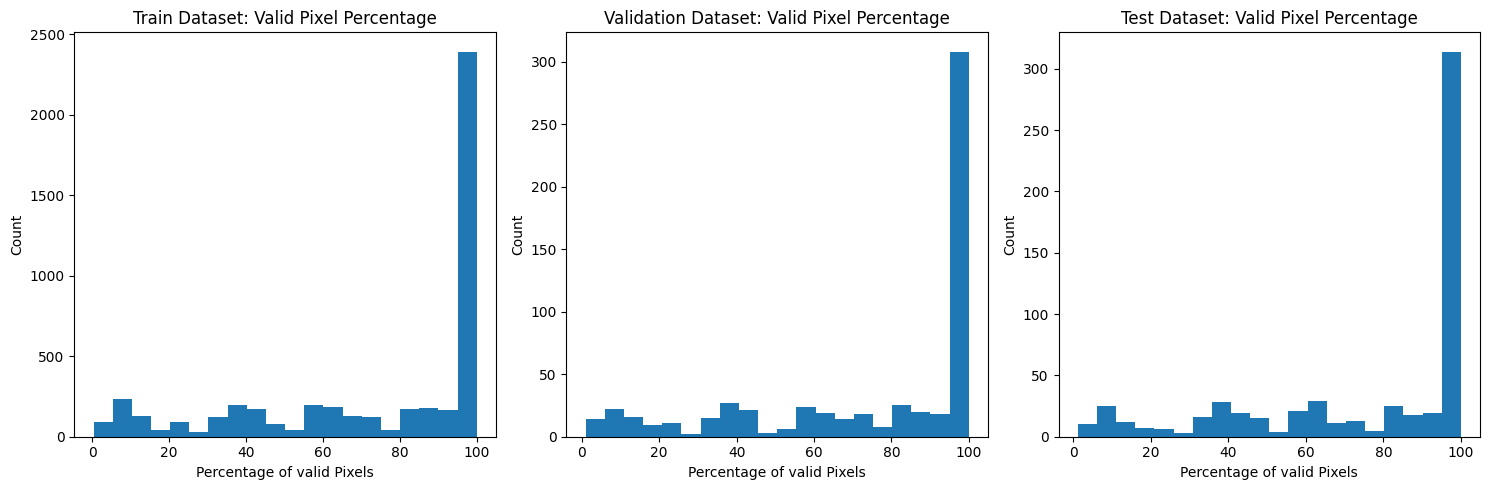

In [21]:
# Plot histograms of missing values
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df_train['missing_value_percentage'], bins=20)
plt.title('Train Dataset: Valid Pixel Percentage')
plt.xlabel('Percentage of valid Pixels')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
plt.hist(df_val['missing_value_percentage'], bins=20)
plt.title('Validation Dataset: Valid Pixel Percentage')
plt.xlabel('Percentage of valid Pixels')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
plt.hist(df_test['missing_value_percentage'], bins=20)
plt.title('Test Dataset: Valid Pixel Percentage')
plt.xlabel('Percentage of valid Pixels')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

## Generate TCI from B02, B03, B04, to check data

In [2]:
DATASET_VERSION = "V2"
TRAIN_DIR = f"/mnt/disk/dataset/sentinel-ai-processor/{DATASET_VERSION}/train/"
VAL_DIR = f"/mnt/disk/dataset/sentinel-ai-processor/{DATASET_VERSION}/val/"
TEST_DIR = f"/mnt/disk/dataset/sentinel-ai-processor/{DATASET_VERSION}/test/"
df = pd.read_csv(f"{TEST_DIR}/target.csv")
df["target_path"] = df["Name"].apply(lambda x: os.path.join(TEST_DIR, "target", os.path.basename(x).replace(".SAFE","")))


In [18]:
def normalize(band, lower_percent=2, upper_percent=98):
    """
    Apply percentile stretching to enhance contrast, only considering valid pixels.
    
    Args:
        band: Input image band as numpy array
        lower_percent: Lower percentile boundary (default 2%)
        upper_percent: Upper percentile boundary (default 98%)
        
    Returns:
        Normalized band with values in [0, 1]
    """
    # Create mask for valid pixels
    valid_mask = (band > 0)
    
    # If no valid pixels, return zeros
    if not np.any(valid_mask):
        return np.zeros_like(band, dtype=np.float32)
    
    # Extract valid pixels for percentile calculation
    valid_pixels = band[valid_mask]
    # Calculate percentiles based only on valid pixels
    lower = np.percentile(valid_pixels, lower_percent)
    upper = np.percentile(valid_pixels, upper_percent)
    
    # Create a copy to avoid modifying the original
    result = band.copy().astype(np.float32)
    
    # Apply stretching only to valid pixels
    result[valid_mask] = np.clip((band[valid_mask] - lower) / (upper - lower), 0, 1)
    
    # Set invalid pixels to 0
    result[~valid_mask] = 0
    
    return result



def read_images(product_paths):

    images = []

    for path in product_paths:

        data = Image.open(path)
        data = np.array(data)
        images.append(data)

    return images

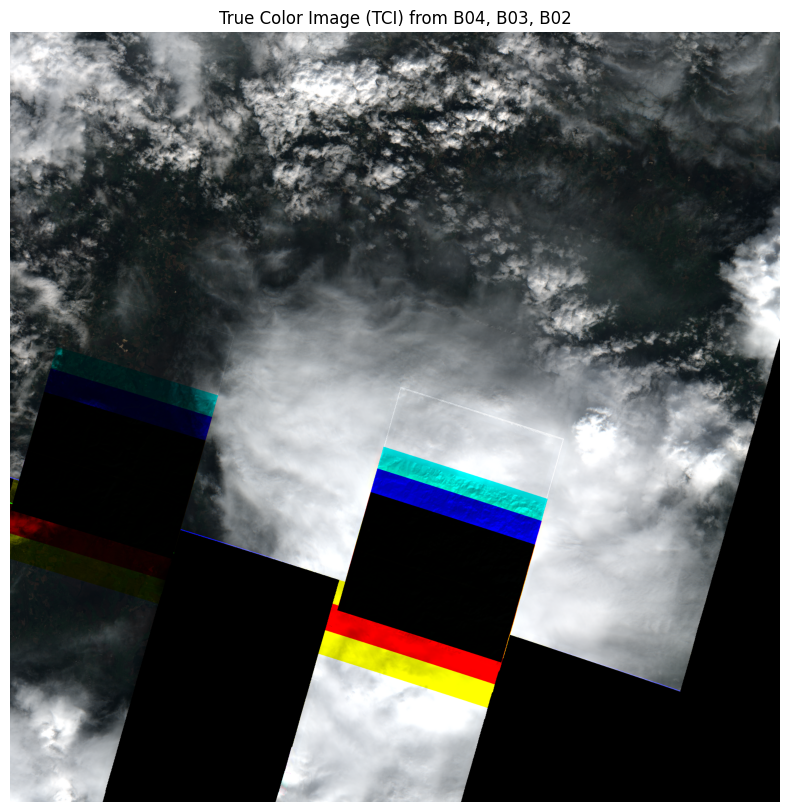

In [33]:
product_paths = natsort.natsorted(glob.glob(os.path.join(df["target_path"].sample(axis=0).values[0], "*.png"), recursive=False))
images = read_images(product_paths)
blue = np.array(Image.open(product_paths[0]))
green = np.array(Image.open(product_paths[1]))
red = np.array(Image.open(product_paths[2]))

# Normalize each band
red_norm = normalize(red)
green_norm = normalize(green)
blue_norm = normalize(blue)

# Stack into RGB image
rgb = np.dstack((red_norm, green_norm, blue_norm))

# Display
plt.figure(figsize=(10, 10))
plt.imshow(rgb)
plt.title("True Color Image (TCI) from B04, B03, B02")
plt.axis('off')
plt.show()

In [34]:
product_paths

['/mnt/disk/dataset/sentinel-ai-processor/V2/test/target/S2B_MSIL2A_20230331T104629_N0509_R051_T31TEN_20230331T135550/T31TEN_20230331T104629_B02_10m.png',
 '/mnt/disk/dataset/sentinel-ai-processor/V2/test/target/S2B_MSIL2A_20230331T104629_N0509_R051_T31TEN_20230331T135550/T31TEN_20230331T104629_B03_10m.png',
 '/mnt/disk/dataset/sentinel-ai-processor/V2/test/target/S2B_MSIL2A_20230331T104629_N0509_R051_T31TEN_20230331T135550/T31TEN_20230331T104629_B04_10m.png']